# Section 7: Cloud-based machine learning (part 1)

Thus far, we have looked at building and fitting ML models “locally.” True, the notebooks have been located in the cloud themselves, but the models with all of their predictive and classification power are stuck in those notebooks. To use these models, you would have to load data into your notebooks and get the results there.

In practice, we want those models accessible from a number of locations. And while the management of production ML models has a lifecycle all its own, one part of that is making models accessible from the web. One way to do so is to develop them using third-party cloud tools, such as [Microsoft Azure ML Studio](https://studio.azureml.net) (not to be confused with Microsoft Azure Machine Learning sService, which provides end-to-end lifecycle management for ML models).

Alternatively, we can develop and deploy a function that can be accessed by other programs over the web—a web service—that runs within Azure ML Studio, and we can do so entirely from a Python notebook. In this section, we will use the [`azureml`](https://github.com/Azure/Azure-MachineLearning-ClientLibrary-Python) package to deploy an Azure ML web service directly from within a Python notebook (or other Python environment).

> <font color=red>**Note:**</font> The `azureml` package presently works only with Python 2. If your notebook is not currently running Python 2, change it in the menu at the top of the notebook by clicking **Kernel > Change kernel > Python 2**.

## Create and connect to an Azure ML Studio workspace

The `azureml` package is installed by default with Azure notebooks, so we don't have to worry about that. It uses an Azure ML Studio workspace ID and authorization token to connect your notebook to the workspace; you will obtain the ID and token by following these steps:

1. Open [Azure ML Studio](https://studio.azureml.net) in a new browser tab and sign in with a Microsoft account. Azure ML Studio is free and does not require an Azure subscription. Once signed in with your Microsoft account (the same credentials you’ve used for Azure Notebooks), you're in your “workspace.”

2. On the left pane, click **Settings**.

    ![Settings button](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-settings.png?raw=true)<br/><br/>

3. On the **Name** tab, the **Workspace ID** field contains your workspace ID. Copy that ID into the `workspace_id` value in the code cell in Step 5 of the notebook below.

    ![Location of workspace ID](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-workspace-id.png?raw=true)<br/><br/>

4. Click the **Authorization Tokens** tab, and then copy either token into the `authorization_token` value in the code cell in Step 5 of the notebook.

    ![Location of authorization token](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-tokens.png?raw=true)<br/><br/>

5. 5.	Run the code cell below; if it runs without error, you're ready to continue.

In [1]:
from azureml import Workspace

# Replace the values with those from your own Azure ML Studio instance; see Prerequisites
# The workspace_id is a string of hexadecimal characters; the token is a long string of random characters.
workspace_id = 'INSERT YOURS HERE'
authorization_token = 'INSERT YOURS HERE'

ws = Workspace(workspace_id, authorization_token)

## Explore forest fire data

Let’s look at a meteorological dataset collected by Cortez and Morais for 2007 to study the burned area of forest fires in the northeast region of Portugal.

> P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. 
  In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, 
  Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, 
  Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. 

The dataset contains the following features:

- **`X`**: x-axis spatial coordinate within the Montesinho park map: 1 to 9
- **`Y`**: y-axis spatial coordinate within the Montesinho park map: 2 to 9
- **`month`**: month of the year: "1" to "12" jan-dec
- **`day`**: day of the week: "1" to "7" sun-sat
- **`FFMC`**: FFMC index from the FWI system: 18.7 to 96.20
- **`DMC`**: DMC index from the FWI system: 1.1 to 291.3 
- **`DC`**: DC index from the FWI system: 7.9 to 860.6 
- **`ISI`**: ISI index from the FWI system: 0.0 to 56.10
- **`temp`**: temperature in Celsius degrees: 2.2 to 33.30
- **`RH`**: relative humidity in %: 15.0 to 100
- **`wind`**: wind speed in km/h: 0.40 to 9.40 
- **`rain`**: outside rain in mm/m2 : 0.0 to 6.4 
- **`area`**: the burned area of the forest (in ha): 0.00 to 1090.84 


Let's load the dataset and visualize the area that was burned in relation to the temperature in that region.

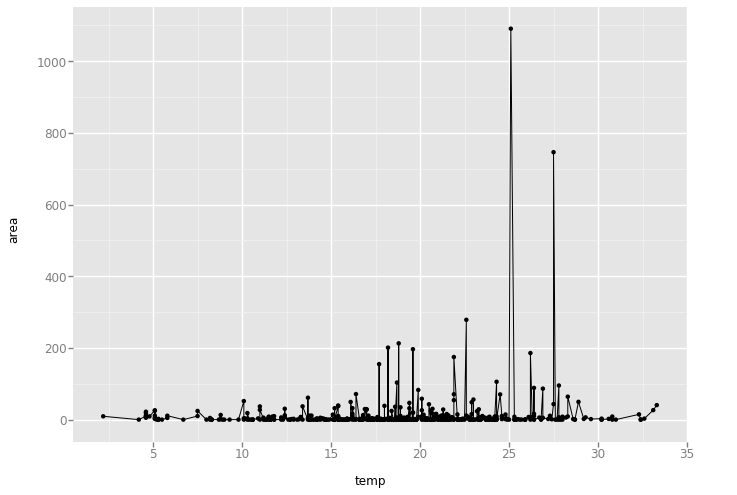

<ggplot: (-9223363293991994876)>

In [2]:
import pandas as pd
df = pd.DataFrame(pd.read_csv('Data/forestfires.csv'))
%matplotlib inline
from ggplot import *
ggplot(aes(x='temp', y='area'), data=df) +  geom_line() + geom_point()

Intuitively, the hotter the weather, the more hectares burned in forest fires.

## Transfer your data to Azure ML Studio

We have our data, but how do we get it into Azure ML Studio in order to use it there? That is where the `azureml` package comes in. It enables us to load data and models into Azure ML Studio from an Azure notebook (or any Python environment.)

The code cell below is a repeat of the one you ran above. If you successfully ran it there, there is no need to do so again (but there is no harm in running it again if you do so). If you have not yet run it, do so now:

In [4]:
from azureml import Workspace

# Replace the values below with those from your own Azure ML Studio instance.
# The workspace_id is a string of hexadecimal characters; 
# the token is a long string of random characters.

workspace_id = 'INSERT YOURS HERE'
authorization_token = 'INSERT YOURS HERE'

ws = Workspace(workspace_id, authorization_token)

Now that you have your notebook talking to Azure ML Studio, you can export your data to it:

In [5]:
from azureml import DataTypeIds

dataset = ws.datasets.add_from_dataframe(
              dataframe=df,
              data_type_id=DataTypeIds.GenericCSV,
              name='Forest Fire Data',
              description='Paulo Cortez and Aníbal Morais (Univ. Minho) @ 2007'
          )

After running the code above, you can see the dataset listed in the **Datasets** section of the Azure Machine Learning Studio workspace. (**Note**: You might need to switch between browser tabs and refresh the page in order to see the dataset.)

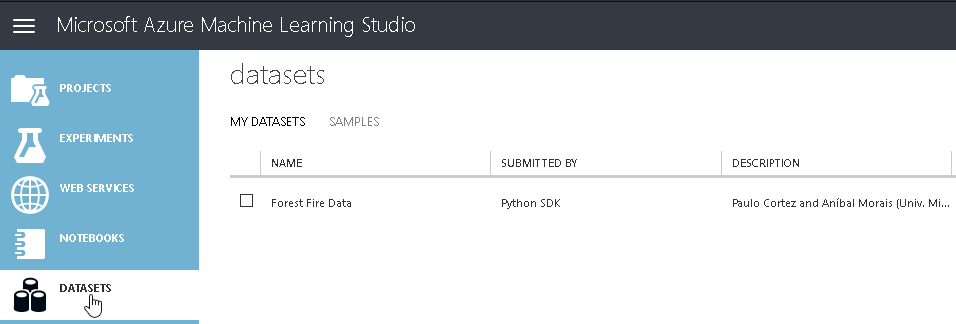<br/>

It is also straightforward to list the datasets available in the workspace and transfer datasets from the workspace to the notebook:

In [6]:
print('\n'.join([i.name for i in ws.datasets if not i.is_example])) # only list user-created datasets

Evaluation results (saved from Evaluate Model)
Forest Fire Data


You can also interact with and examine the dataset in Azure ML Studio directly from your notebook:

In [7]:
# Read some more of the metadata
ds = ws.datasets['Forest Fire Data']
print(ds.name)
print(ds.description)
print(ds.family_id)
print(ds.data_type_id)
print(ds.created_date)
print(ds.size)

# Read the contents
df2 = ds.to_dataframe()
df2.head()

Forest Fire Data
Paulo Cortez and Aníbal Morais (Univ. Minho) @ 2007
1be4c10265b84cc9b3ce9a7d5316055f
GenericCSV
2019-06-05 21:48:12.529000
25557


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,3,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,7,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Create your model

We're now back into familiar territory: prepping data for the model and fitting the model. To keep it interesting, we'll use the scikit-learn `train_test_split()` function with a slight change of parameters to select 75 percent of the data points for training and 25 percent for validation (testing).

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        df[['wind','rain','month','RH']],
        df['temp'],
        test_size=0.25,
        random_state=42
    )

Did you see what we did there? Rather than select all of the variables for the model, we were more selective and just chose windspeed, rainfall, month, and relative humidity in order to predict temperature.

Fit scikit-learn's `DecisionTreeRegressor` model using the training data. This algorithm is a combination of the linear regression and decision tree classification that you worked with in Section 6.

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_test_predictions = regressor.predict(X_test)
print('R^2 for true vs. predicted test set forest temperature: {:0.2f}'.format(r2_score(y_test, y_test_predictions)))

R^2 for true vs. predicted test set forest temperature: 0.63


In [10]:
# Play around with this algorithm. 
# Can you get better results changing the variables you select for the training and test data?
# What if you look at different variables for the response?


## Deploy your model as a web service

This is the important part. Once deployed as a web service, your model can be accessed from anywhere. This means that rather than refit a model every time you need a new prediction for a business or humanitarian use case, you can send the data to the pre-fitted model and get back a prediction.

First, deploy the model as a predictive web service. To do so, create a wrapper function that takes input data as an argument and calls `predict()` with your trained model and this input data, returning the results.

In [11]:
from azureml import services

@services.publish(workspace_id, authorization_token)
@services.types(wind=float, rain=float, month=int, RH=float)
@services.returns(float)

# The name of your web service is set to this function's name
def forest_fire_predictor(wind, rain, month, RH):
    return regressor.predict([wind, rain, month, RH])

# Hold onto information about your web service so 
# you can call it within the notebook later
service_url = forest_fire_predictor.service.url 
api_key = forest_fire_predictor.service.api_key
help_url = forest_fire_predictor.service.help_url
service_id = forest_fire_predictor.service.service_id

AttributeError: 'Arguments' object has no attribute 'keywords'

You can also go to the **Web Services** section of your Azure ML Studio workspace to see the predictive web service running there.

## Consuming the web service

Next, consume the web service. To see if this works, try it here from the notebook session in which the web service was created. Just call the predictor directly:

In [ ]:
forest_fire_predictor.service(5.4, 0.2, 9, 22.1)

At any later time, you can use the stored API key and service URL to call the service. In the example below, data can be packaged in JavaScript Object Notation (JSON) format and sent to the web service.

In [ ]:
import urllib2
import json

data = {"Inputs": { 
            "input1": {
                "ColumnNames": [ "wind", "rain", "month", "RH"],
                "Values": [["5.4", "0.2", "9", "22.1"]] 
            }
        }, # Specified feature values
        
        "GlobalParameters": {}
    }

body = json.dumps(data)
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
req = urllib2.Request(service_url, body, headers) 

try:
    response = urllib2.urlopen(req)
    result = json.loads(response.read())  # load JSON-formatted string response as dictionary
    print(result['Results']['output1']['value']['Values'][0][0]) # Get the returned prediction
    
except urllib2.HTTPError, error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(json.loads(error.read()))         

> **Exercise**:

Try this same process of training and hosting a model through Azure ML Studio with the Pima Indians Diabetes dataset (in CSV format in your data folder). The dataset has nine columns; use any of the eight features you see fit to try and predict the ninth column, Outcome (1 = diabetes, 0 = no diabetes).

> **Takeaway**: In this part, you explored fitting a model and deploying it as a web service. You did this by using now-familiar tools in an Azure Notebook to build a model relating variables surrounding forest fires and then posting that as a function in Azure ML Studio. From there, you saw how you and others can access the pre-fitted models to make predictions on new data from anywhere on the web.

You have now created your own ML web service. Let's now see how you can also interact with existing ML web services for even more sophisticated applications.